In [52]:
include("MiniCollectiveSpins.jl")
using PyPlot
using Statistics
using JLD2
using OrdinaryDiffEq
import PhysicalConstants.CODATA2018: c_0
using Unitful
using ProgressMeter
using NonlinearSolve
using SteadyStateDiffEq 
using BenchmarkTools

In [53]:
""" Prepare the initial vector u0 """
function u0_CFunction(phi_array, theta_array, op_list)
    u0 = ones(ComplexF64, length(op_list))
    for i in 1:length(op_list)
        if length(op_list[i]) == 1
            j = Int(op_list[i][1] % 10^floor(log10(abs(op_list[i][1]))-1)) # Atom nbr
            if parse(Int, string(op_list[i][1])[1:2]) == 22
                u0[i] = cos(theta_array[j]/2)^2
            elseif parse(Int, string(op_list[i][1])[1:2]) == 21
                u0[i] = cos(theta_array[j]/2)*exp(1im*phi_array[j])*sin(theta_array[j]/2)
            else
                println(op_list[i][1])
            end
        end

        if length(op_list[i]) == 2
            for op in op_list[i]
                j = Int(op % 10^floor(log10(abs(op))-1)) # Atom nbr
                if parse(Int, string(op)[1:2]) == 22
                    u0[i] *= cos(theta_array[j]/2)^2
                elseif parse(Int, string(op)[1:2]) == 21
                    u0[i] *= cos(theta_array[j]/2)*exp(1im*phi_array[j])*sin(theta_array[j]/2)
                elseif parse(Int, string(op)[1:2]) == 12
                    u0[i] *= cos(theta_array[j]/2)*exp(-1im*phi_array[j])*sin(theta_array[j]/2)
                else
                    println(op)
                end
            end
        end
    end
    return u0
end


""" Create a random distribution, save it, computes the corresponding parameters an return the stationnary state. 
If compute_t_evolution, compute the whole evolution, else only the stationnary state. """
function solve_random_distrib(chunk, f, op_list, N, n, d0_lb, compute_t_evolution)
    popup_ss, nbr_error_ss = [], []
    popup_t, nbr_error_t, list_t = [], [], []

    for i in chunk
        # Compute distribution
        L = (N/n)^(1/3) # Change the volume to keep the density cste
        r0 = [[rand(Float64)*L, rand(Float64)*L, rand(Float64)*L] for i in 1:N]

        # Choose a distribution where the minimum distance between the atoms is bigger than d0_min
        while min_r0(r0) < d0_lb
            r0 = [[rand(Float64)*L, rand(Float64)*L, rand(Float64)*L] for i in 1:N]
        end

        # Save the atoms position for comparison with QuantumOptics
        @save "r0/r0_N_$(N)_r_$i.jdl2" r0 L

        # Compute the parameters
        system = SpinCollection(r0, e, gammas=1.)
        Ω_CS = OmegaMatrix(system)
        Γ_CS = GammaMatrix(system)
        Γij_ = [Γ_CS[i, j] for i = 1:N for j=1:N]
        Ωij_ = [Ω_CS[i, j] for i = 1:N for j=1:N if i≠j]
        exp_RO_ = [exp(1im*r0[i]'kl) for i = N:-1:1] # We go in the decreasing direction to avoid exp_RO(10) being replace by exp_RO(1)0
        conj_exp_RO_ = [exp(-1im*r0[i]'kl) for i = N:-1:1]
        p0 = ComplexF64.([Γij_; Ωij_; exp_RO_; conj_exp_RO_; Ω_RO/2])
        
        # Load the functions
        fsolve(du, u, p, t) = f(du, u, p0)

        if compute_t_evolution
            phi_array_0, theta_array_0 = zeros(N), ones(N)*π # We start from all the atoms in the GS
            u0 = u0_CFunction(phi_array_0, theta_array_0, op_list)

            prob = OrdinaryDiffEq.ODEProblem(fsolve, u0, (T[1], T[end]))
            
            println("Time Evolution")
            sol = OrdinaryDiffEq.solve(prob, OrdinaryDiffEq.DP5();
                        reltol=1.0e-5,
                        abstol=1.0e-5)

            if SciMLBase.successful_retcode(sol)
                push!(list_t, sol.t)
                push!(popup_t, [sum(real(sol.u[i][1:N])) for i=1:length(sol.t)])
            else
                push!(nbr_error_t, i)
            end
            
            uf = sol.u[end]
            print(uf)

        else
            phi_array_f, theta_array_f = zeros(N), ones(N)*3π/4 # We start from all the atoms in the GS
            uf = u0_CFunction(phi_array_f, theta_array_f, op_list)
        end

        ## Computation steady state ##
        println(i)
        println(sum(real(uf[1:N])))


        println("Stationnary state")
        prob_ss = SteadyStateProblem(fsolve, uf)
        sol_ss = solve(prob_ss, DynamicSS(DP5());
                        reltol=1.0e-5,
                        abstol=1.0e-5) # ; maxiters=10_000, abstol=1e-1, reltol=1e-1
        if SciMLBase.successful_retcode(sol_ss)
                push!(popup_ss, sum(real(sol_ss[1:N])))
            else
                push!(nbr_error_ss, i)
                push!(popup_ss, [-1])
        end

    end
    return popup_ss, nbr_error_ss, popup_t, nbr_error_t, list_t
end

""" Return the minimum distance of a distribution of atoms r0 """
function min_r0(r0)
    N = length(r0)
    d0 = zeros(N, N) # Repetiton, atom i, distance from atom j
    for j in 1:N
        for k = 1:N
            d0[j, k] = norm(r0[j]-r0[k])
        end
    end
    return minimum(d0[d0 .> 0])
end

min_r0

### Define the system

In [54]:
# Nbr of particles
N = 4
r = 5 # Nbr of repetitions

# Normalisation parameters
λ = 421e-9
γ = 32.7e6 # In Hz

# Physical values
ω0 = (2π*ustrip(c_0)/λ)
ωl = ω0
kl = [ustrip(c_0)/ωl, 0, 0] # Laser along x
Ω_RO = 1e7 # Taken from Barbut arXiv:2412.02541v1

# Fixed density
n0 = 100#2e3 # atoms per unit of volume (already normalized)
d0_lb = 1e-10 # Minimum distance between the atoms (lower boundary) in m

# Normalization
ω0 = ω0 / γ
ωl = ωl / γ
kl = kl * λ
Ω_RO = Ω_RO / γ
d0_lb = d0_lb/λ

# Quantization axis along z
e = [0, 0, 1.]

# Integration parameter
tstep = 0.1
T = [0:tstep:100;]; # Normalised time

### Compute stationnary state for r repetitions

In [55]:
# Create the directories
if !isdir("r0")
    mkdir("r0")
end
if !isdir("Images_distribution")
    mkdir("Images_distribution")
end
if !isdir("solutions")
    mkdir("solutions")
end
nothing 

In [56]:
# Prepare the function
libpath ="libs/liballfuncs_$N.dll"
f(du, u, params) = ccall(("diffeqf", libpath), Cvoid, (Ptr{ComplexF64}, Ptr{ComplexF64}, Ptr{ComplexF64}), du, u, params)

f (generic function with 1 method)

In [57]:
@load "op_list/op_list_$N.jdl2" op_list
list_r = 1:r
chunks = Iterators.partition(list_r, cld(length(list_r), Threads.nthreads()))

solve_random_distrib(1, f, op_list, N, n0, d0_lb, true)

tasks = map(chunks) do chunk # Split the different distributions into chuncks solved on each core
    Threads.@spawn solve_random_distrib(chunk, f, op_list, N, n0, d0_lb, true)
end

# Gather the data from the different threads
sol_tasks = fetch.(tasks)
popup_ss, nbr_error_ss = vcat([s[1] for s in sol_tasks]...), vcat([s[2] for s in sol_tasks]...)
popup_t, nbr_error_t, sol_t = vcat([s[3] for s in sol_tasks]...), vcat([s[4] for s in sol_tasks]...), vcat([s[5] for s in sol_tasks]...)
println("Nbr errors SS = "*string(length(nbr_error_ss)))
println("Nbr errors t_evol = "*string(length(nbr_error_t)))

Time Evolution
ComplexF64[0.0048454925057221584 + 0.0im, 0.013159004885527646 - 3.4971499206986963e-19im, 0.03989040050440603 + 1.1716230305601835e-18im, 0.0018364885132801498 - 2.6779444214088907e-21im, -0.07217935549034395 - 0.0035134013839220484im, -0.10753083124846526 - 0.0317156057244525im, 0.1706840316709369 + 0.08621840904979028im, 0.004780001674919512 + 0.008167540606871864im, 0.008884220231806758 - 0.0015777880868042017im, -0.012878035831505113 + 0.005428725088258448im, 0.00013028424257133865 + 0.00029597227657157795im, -0.021885045130318158 + 0.004418778655625505im, -0.0018219412677220137 + 3.1187312753363483e-6im, 0.0006767019592556557 + 0.0004514442091432168im, -0.0010380753114396619 + 0.0015291616754098834im, -0.0018376943378904688 + 0.0008614320068565782im, -8.061520547218382e-5 + 0.00010025373986064485im, -0.00083351767859588 + 0.0009472695620720083im, -0.0003730999267545805 - 0.0010604173373841763im, -0.00014083998192163777 - 0.00024327035393842118im, 0.0007002943956667

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\Joschka\.julia\packages\SciMLBase\TZ9Rx\src\integrator_interface.jl:626


Time Evolution
Time Evolution
Time Evolution
Time Evolution
Time Evolution
ComplexF64[0.012675602373062124 + 8.577940869659956e-21im, 0.013799909528254125 - 1.7278855526055727e-20im, 0.001073651376699047 + 8.62678004399178e-20im, 0.02980698010756903 - 1.191412380820618e-19im, 0.028346760792321606 + 0.10086385308886997im, -0.004395408943903464 + 0.11398565566348613im, -0.0117583001364293 + 0.014400188803789644im, -0.03898247135268339 + 0.1607673286358978im, 0.01106384775503575 - 0.0035042071069379182im, 0.0010668006037173896 - 0.0017372499377931929im, 0.013592934411726135 - 0.00795030734914824im, 0.0014532972407449677 - 0.0014413256949961045im, 0.01870526747827849 - 0.0038071416639609127im, 0.002530060713894608 + 0.001177563098206693im, 0.0005124966962365567 + 0.0014109115173813085im, 1.2226500154016327e-5 + 2.06095085135268e-5im, 0.001662870476246918 + 0.0056083415423854215im, 2.7278016685314845e-5 + 0.0015149151329754im, 0.00023843382896731504 + 2.6129371598037155e-5im, -0.00035147829

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\Joschka\.julia\packages\SciMLBase\TZ9Rx\src\integrator_interface.jl:626
┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\Joschka\.julia\packages\SciMLBase\TZ9Rx\src\integrator_interface.jl:626


Nbr errors SS = 2
Nbr errors t_evol = 0


In [58]:
@save "solutions/sol_N_$(N)_r_$(r)" popup_ss nbr_error_ss popup_t nbr_error_t

In [59]:
@load "solutions/sol_N_$(N)_r_$(r)" popup_ss nbr_error_ss popup_t nbr_error_t

4-element Vector{Symbol}:
 :popup_ss
 :nbr_error_ss
 :popup_t
 :nbr_error_t

# Plots SS

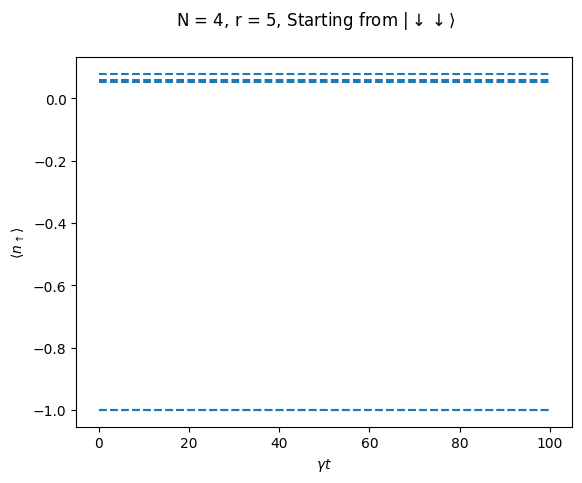

In [60]:
fig, ax = subplots()
for i in 1:length(popup_ss)
    ax.hlines(popup_ss[i], T[1], T[end], linestyle="--")
end
ax.set_xlabel(L"$\gamma t$")
ax.set_ylabel(L"$\langle  n_{\uparrow} \rangle $")

suptitle("N = $N, r = $r, Starting from "*L"$|\downarrow \downarrow \rangle $")
pygui(false);
# pygui(true); show()

# Plots with time evolution

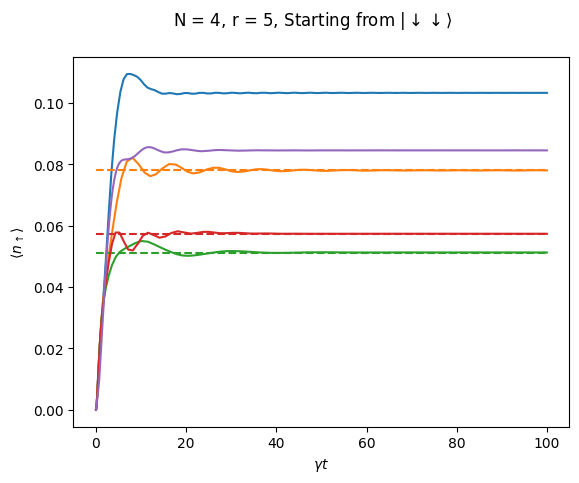

In [61]:
fig, ax = subplots()
for i in 1:length(popup_t)
    line, = ax.plot(sol_t[i], popup_t[i])
    if i ∉ nbr_error_ss
        ax.hlines(popup_ss[i], T[1], T[end], linestyle="--", color = line.get_color())
    end
end
ax.set_xlabel(L"$\gamma t$")
ax.set_ylabel(L"$\langle  n_{\uparrow} \rangle $")

suptitle("N = $N, r = $r, Starting from "*L"$|\downarrow \downarrow \rangle $")
pygui(false); gcf();
# pygui(true); show()